# Issue Report Analysis

"""

    1. Create a folder in the issue_reports folder to keep it tidy.
    2. Upload your file(s) on the left side using the Upload files button or drag and drop (it's stored on an S3 AWS cloud)
    3. Add your file to the bottom of the file_url list below
    4. Run the entire notebook by using `Run All Cells` from the Run menu or push `shift+enter` or arrow above to execute each cell separately.

If you want to create your own analysis, Duplicate the file by using the right mouse button on the file or use the menu bar on the left.

file: Analysis_MDB.ipynb

version: 2019-02-17 

    Note - this version is complimentary to Eelke's.  We copied ideas back and forth for a while, but have diverged somewhat.
    would love to figure out how to set up functions in separate files so we could share
    For now, just see if can print out to a pretty file format at the very end - leave the earlier stuff alone
    
version: 2019-02-18 WIP

    Pete explained that it is the Pod battery that is waked up and stays awake for 30 sec after the last command
        and that there are a lot of low level exchanges that are captured as a single line in the messageLogs
        
    So add a new sleep time calculation based on this information and see if it differs from Eelke's elegant method
    
    For each sequence
        Check that first message is a send
        Check that last message is a receive
        If true - then awake time is [lastInSeq-SecondInSeq]+30 sec
        
    Pete says to just count the number of instances of sendOnly and don't worry about odd and even, so modify code to:
        Calculate pod_radio_awake_time
        
    I already have a function that finds times for single send from RL with no response from pump
         and that's being plotted with red dots in the figure

    
"""

In [1]:
# other people's files:
"""

file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Eelke/Loop Report 2019-02-10 22:16:27+01:00.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Ben/Loop-Report-2019-02-09-223401-0600.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Ben/Loop-Report-2019-02-12-173646-0600.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Eelke/Loop Report 2019-02-17 10:09:17+01:00.md'
# Extract through end of MessageLogs for Alessandro - otherwise too big to upload
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Alessandro/MessageLogs-2019-02-14-1320570100_0x40_800MHzRL.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Alessandro/MessageLogs-2019-02-17-0921340100_0x40_800MHzRL.md'
# Joe
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Joe/Loop-Report-2019-02-18-131406-0800_0x14.md'
# Ben $34, just started with 433MHz RL, Code from 2/12/2019
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Ben/MessageLogsFrom_Loop-Report-2019-02-18-201950-0600_0x34.md'

"""

# my reports:
"""
Keep list, in order, of my reports.  Copy the one I want to analyze below the comment mark then run workbook

file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_18_Body_0113_Nominal_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_19_Body_0115_Nominal_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_20_Body_0115_0x34_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_21_Body_0119_Nominal_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_22_Nominal_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_23_Nominal_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_24_Success_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Pod_25_Success_Combined_MessageLogs.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-04 06_46_21-08_00_Pod26.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-06 18_38_18-0800_Pod27suspend.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-08 20_46_16-05_00_Pod28_SuspendBeforeDeactivate.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-11 08_48_13-05_00_Pod29suspendBeforeDeactivate.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-13 19_56_48-05_00_Pod30suspendedEmpty.md'
file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-16 16_27_05-08_00_Pod31beforeRebuildLastSaved.md'


"""

file_url = 'https://omnikit-lab.herokuapp.com/files/issue_reports/Marion/Loop Report 2019-02-16 16_27_05-08_00_Pod31beforeRebuildLastSaved.md'

# slice the string to just include sub-folder and filename
thisFile = file_url[54:-3]



### Load all packages

In [2]:
%matplotlib inline
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
import re
import pandas as pd

# add these two packages for the sequence and statistics calculations
from collections import Counter
import numpy as np


### Load and parse file

In [3]:
def load_file(file_url):
    commands = []
    file = requests.get(file_url)
    xcode_log_text = file.text
    # print(xcode_log_text)
    regex = r"\* ([0-9-:\s]*)\s.*\s(send|receive)\s([a-z0-9]*)\n*"
    select_1a_commands = re.findall(regex, xcode_log_text, re.MULTILINE)
    for line in select_1a_commands:
        commands.append({"time": line[0], "type": line[1], "raw_value": line[2][12:]})
    return commands
commands = load_file(file_url)

In [4]:
# control the output here, numRowsXXX is number of rows printed at the beginning and end of the command list
verboseFlag =  0   # if this is 1 then more print stmts
numRowsBeg  =  0   # if >0, print this many messages from beginning of record
numRowsEnd  =  0   # if >0, print this many messages from end of record

# set up the asleep time as an adjustable parameter
#   Eelke hard coded 30 sec - which is the time the radio stays on for the Pod
radio_on_time   = 30 # add new variable name, same as sleep_time_param


In [5]:
# Uncomment line below if you want to see the output of the parsed file to a dictonary:
# print(commands)

In [6]:
def select_extra_command(raw_value):
    if raw_value[:2]=='1a':
        if raw_value[32:34] not in ['16','17']:
            return 13
        else:
            return raw_value[32:34]

In [7]:
def generate_table(commands):
    df = pd.DataFrame(commands)
    df['time'] = pd.to_datetime(df['time'])
    df['command'] = df['raw_value'].str[:2].astype(str)+df['raw_value'].apply(select_extra_command).fillna('').astype(str)
    df['time_delta'] = (df['time']-df['time'].shift()).dt.seconds.fillna(0).astype(float)
    df['time_asleep'] = df['time_delta'].loc[df['time_delta'] > radio_on_time] - radio_on_time  # radio_on_time seconds the radio stays awake
    return df
df = generate_table(commands)


In [8]:
if numRowsBeg>0:
    display(df.head(numRowsBeg))

In [9]:
if numRowsEnd>0:
    display(df.tail(numRowsEnd))

# Total time, Send/Recv, Awake/Asleep

In [10]:
summary = {}

first_command = df.iloc[0]['time']
last_command = df.iloc[-1]['time']
run_time_hours = last_command-first_command
run_time_hours = run_time_hours.total_seconds()/3600

summary['first_command'] = df.iloc[0]['time']
summary['total time'] = '{}'.format(last_command - first_command)

send_receive_commands = df.groupby(['type']).size()

summary['# Sent to Pod'] = send_receive_commands[1]
summary['# Received from Pod']= send_receive_commands[0]

summary['# Send and Received']= df['command'].count()

asleep_time = (round(df['time_asleep'].sum()/df['time_delta'].sum() * 100 ,2))
summary['Asleep Time'] = '{} %'.format(asleep_time)
summary['Awake Time'] = '{} %'.format(round(100 - asleep_time , 4))

if verboseFlag:
    print('{:.2f}'.format(run_time_hours))
    


In [11]:
# Summary and Total commands by type

In [12]:
# move all printouts to end
if verboseFlag:
    print('__________________________________________')
    for key, value in summary.items():
        print(key.ljust(19).title(),':',value)
    print('__________________________________________')

verboseFlag = 0
if verboseFlag:
    display(df.groupby(['type','command']).size().reset_index(name='count'))

In [13]:
# calculate average times between messages

mean_seconds_time_delta = (df['time_delta']).mean()
mean_receive_time_delta = (df.loc[df['type'] == 'receive']['time_delta']).mean()

if verboseFlag:
    print('Average time between commands =',time.strftime("%H:%M:%S",time.gmtime(mean_seconds_time_delta.astype(int))))
    print('Average time between commands =',round(mean_seconds_time_delta/60,3), 'minutes')
    print('Average receive time after send command =',round(mean_receive_time_delta,3), 'seconds')


## Distribution

In [14]:
# This cell contains function definitions

# generate a list of sequences (command/response groupings) from the dataframes
def generate_sequence(frame):
    # returns a list of the indices to dataframes that are part of a single sequence
    # This list will hold our indices
    list_of_sequences = []
    # This list is a sequence, remember to clear it after appending to the big list
    sequence = []
    for index, row in frame.iterrows():
        if pd.isna(row['time_asleep']):
            sequence.append(index)
        else:
            list_of_sequences.append(sequence)
            del(sequence)
            sequence = []
            sequence.append(index)
            
    return list_of_sequences


# prepare of list of the number of individual commands in each sequence
# this returns tuples of [number of commands in a sequence, number of sequences with that length]
def count_cmds_per_sequence(list_of_sequences):
    sequence_counter = Counter()
    for sequence in list_of_sequences:
        sequence_counter[len(sequence)] += 1
        
    return list(sequence_counter.items())


# prepare an array of the time since pod started to the first command in each 
# sequence and the number of commands in that sequence
def create_time_vs_sequenceLength(frame, list_of_sequences):
    """
    Returns a list of tuples (time since first command, length of sequence).
    
    PARAMS:
        frame (pandas.DataFrame): The pandas dataframe of commands
        list_of_sequences (list): The list of sequences from generate_sequence()
        
    RETURNS:
        time_vs_sequenceLength (list): 
          list of tuples (
              time in hours since pod start, 
              length of messages,
              cummulative time (hours) pod radio is awake
              )
    """
    # initialize some stuff
    time_vs_sequenceLength = []
    first_command = frame.iloc[0]['time']
    pod_radio_awake_time = 0.0
    
    for sequence in list_of_sequences:
        timeDelta_since_beginning = (frame.iloc[sequence[0]]['time']-first_command)
        time_since_beginning_hrs = timeDelta_since_beginning.total_seconds()/3600
        seqLength = len(sequence)
        timeInSequence = (frame.iloc[sequence[seqLength-1]]['time']-frame.iloc[sequence[0]]['time'])
        timeInSequence_sec = timeInSequence.total_seconds()
        thisTime =  (timeInSequence_sec + radio_on_time)/3600
        if seqLength >= 1:
            pod_radio_awake_time += thisTime
        
        time_vs_sequenceLength.append((time_since_beginning_hrs, seqLength, pod_radio_awake_time))
    
    return time_vs_sequenceLength

# prepare all single sequence commands
def create_singleton_times(time_vs_sequenceLength):
    time_for_singleton = []
    for item in time_vs_sequenceLength:
        if item[1] == 1:
            time_for_singleton.append(item[0])
        
    return time_for_singleton



In [15]:
# These cells use the functions created above

# Prepare a list of the indices to dataframes that are part of a single sequence
sequence_of_cmds = generate_sequence(df)
number_of_messages = len(df)
number_of_sequences = len(sequence_of_cmds)

# Prepare of list of the number of individual commands in each sequence
#     tuples of [number of commands in a sequence, number of sequences with that length]
cmds_per_sequence = count_cmds_per_sequence(sequence_of_cmds)


# Prepare an array of the time since pod started to the first command in each 
#   sequence and the number of commands in that sequence and radio on time
time_vs_sequenceLength = create_time_vs_sequenceLength(df, sequence_of_cmds)
lastElement = time_vs_sequenceLength[-1]


In [16]:
# break into times (hours since pod start) and #cmds in sequence for plotting
times = [x[0] for x in time_vs_sequenceLength]
lengths = [y[1] for y in time_vs_sequenceLength]
singleton_times = create_singleton_times(time_vs_sequenceLength)
number_of_singletons = len(singleton_times)
singleton_ones = [1 for n in range (0, number_of_singletons)]

# print(f'singleton_times = {singleton_times}')
# print(f'singleton_ones = {singleton_ones}')
#print(f'cmds_per_sequence = {cmds_per_sequence}')
    
seqDelTime = [times[n+1]-times[n] for n in range (0, len(times)-1)]
# print('First and last seqDelTime (hrs) =', seqDelTime[0],  seqDelTime[-1])
# print('First and last seqDelTime (min) =', 60.0*seqDelTime[0],  60.0*seqDelTime[-1])

medSeqDelTime  = 60.0*np.median(seqDelTime)  # median time in minutes
meanSeqDelTime = 60.0*np.mean(seqDelTime) # mean time in minutes
minSeqDelTime  = 60.0*np.min(seqDelTime)  # min time in minutes
maxSeqDelTime  = 60.0*np.max(seqDelTime)  # max time in minutes

In [17]:
if verboseFlag:
    print(' Summary for MessageLogs in ', thisFile)
    print('__________________________________________\n')
    print('  {:5.2f}'.format(lastElement[0]), ' Pod Hours ')
    print('  {:5.2f}'.format(lastElement[2]), ' Pod Radio On (Hours)', '({:5.1f}% of time)'.format(100*lastElement[2]/lastElement[0]) )
    print('  {:5d}'.format(len(singleton_times)), ' # Send Only Messages ({:5.1f}%'.format(100*len(singleton_times)/len(times)), 'of {:d} sequences)'.format(len(times)))
    print('  {:5d}'.format(send_receive_commands[1]), 'Sends')
    print('  {:5d}'.format(send_receive_commands[0]), 'Receives')
    print('__________________________________________\n')

In [18]:

if verboseFlag:
    print(' Summary for', thisFile)
    print('__________________________________________\n')
    for key, value in summary.items():
        print(key.ljust(19).title(),':',value)
    #print('__________________________________________\n')
    #print(' {:5d}'.format(len(df)), 'Total Exchanges')
    #print(' {:5d}'.format(send_receive_commands[1]), 'Sends')
    #print(' {:5d}'.format(send_receive_commands[0]), 'Receives')
    print('__________________________________________\n')
    
if verboseFlag:
    print(' {:5d}'.format(number_of_sequences), 'Sequences')
    print('  Minutes between sequence start: median, mean, min, max ')
    print('  {:5.2f},'.format(medSeqDelTime), '{:5.2f},'.format(meanSeqDelTime), '{:5.2f},'.format(minSeqDelTime), '{:5.2f}'.format(maxSeqDelTime))
    print('__________________________________________\n')

# parse the number of mesages in the sequences
seq2 = seq3 = seq4 = seq6 = 0
for idx in cmds_per_sequence:
    if idx[0] == 2:
        seq2 += idx[1]
    if idx[0] == 3:
        seq3 += idx[1]
    if idx[0] == 4:
        seq4 += idx[1]
    if idx[0] == 6:
        seq6 += idx[1]

print(' Summary for', thisFile)
print('__________________________________________\n')
print('  Instances, Number of S/R in Sequence')
for idx in cmds_per_sequence:
    print(' {:5d}'.format(idx[1]), ' {:8d}'.format(idx[0]))
print('__________________________________________\n')

cmd_count = df.groupby(['type','command']).size().reset_index(name='count')
display(cmd_count)
# manually read the number of 06 receives

# set up a table format
print('firstTimeUTC, podOn(hrs), radioOn(hrs), numMessages, numSend, numRecv, medianMinBetweenSeq, #Sequences, #of1, #of2, #of4, #of6')
print(f'{first_command},', '{:.2f},'.format(run_time_hours), '{:5.2f},'.format(lastElement[2]), \
      f'{number_of_messages}, {send_receive_commands[1]}, {send_receive_commands[0]},', \
      '{:5.2f},'.format(medSeqDelTime), \
      '{:5d},'.format(number_of_sequences), '{:5d},'.format(number_of_singletons), '{:5d},'.format(seq2), \
      '{:5d},'.format(seq4), '{:5d}'.format(seq6))

 Summary for Marion/Loop Report 2019-02-16 16_27_05-08_00_Pod31beforeRebuildLastSaved
__________________________________________

  Instances, Number of S/R in Sequence
     3        12
   259         2
   284         4
    21         6
    10         8
    26        10
    21        14
     8         1
     2         3
__________________________________________



,type,command,count
0,receive,01,2
1,receive,06,6
2,receive,1d,1219
3,send,03,1
4,send,07,1
5,send,08,1
6,send,0e,411
7,send,11,2
8,send,19,4
9,send,1a13,9


firstTimeUTC, podOn(hrs), radioOn(hrs), numMessages, numSend, numRecv, medianMinBetweenSeq, #Sequences, #of1, #of2, #of4, #of6
2019-02-14 01:02:32, 71.33,  6.70, 2466, 1239, 1227,  5.05,   634,     8,   259,   284,    21


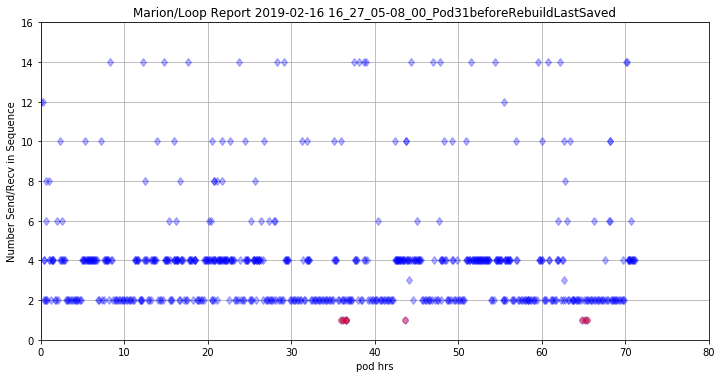

In [19]:
# This cell prepares the plot for the number of commands per sequence vs time
       
# Plot the number of commands in each sequence vs time since pod was paired
#fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(color='lightgray', linestyle='-', linewidth=1)
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
ax = plt.subplot2grid((1, 1), (0, 0))
ax.plot(times, lengths, marker='d', linestyle='None', alpha=0.3, c='b', markersize=6)
ax.set_xlabel('pod hrs')
ax.set_ylabel('Number Send/Recv in Sequence')
plt.grid()
ax.plot(singleton_times, singleton_ones, marker='o', linestyle='None', alpha=0.3, c='r', markersize=6)
ax.set_xlim(0, 80)
ax.set_ylim(0, max(lengths)+2)
ax.set_title(thisFile)


plt.show()

            

In [20]:
# Resync nonce
df.loc[df['command'].isin(['06','02'])]

,raw_value,time,type,command,time_delta,time_asleep
1522,060314314880c0,2019-02-15 20:47:24,receive,06,1.0,NaN
1524,0603142d9f8308,2019-02-15 20:47:26,receive,06,1.0,NaN
1559,060314f07b836f,2019-02-15 21:17:24,receive,06,1.0,NaN
1561,060314753b0221,2019-02-15 21:17:28,receive,06,2.0,NaN
2236,060314685c828c,2019-02-16 15:54:00,receive,06,2.0,NaN
2238,060314942203b9,2019-02-16 15:54:05,receive,06,4.0,NaN
